In [1]:
import os
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('../src')
sys.path.append('../../src')
from Library import VerboseLibrary
from ActivityClassifier import PatientTrendAwareThresholder
import matplotlib.colors as mcolors

named_colors = list(mcolors.TABLEAU_COLORS)

device = 'cpu'#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Models

In [2]:
model_names = sorted(os.listdir('./models_PTAT'))
len(model_names)

10

In [3]:
model_coefficient_history = {}
model_coefficient_mask = {}
model_coefficients = {}

for name in tqdm(model_names):
    model = torch.load(os.path.join('.', 'models_PTAT', name)).to(device)
    model_coefficient_history[name] = np.array(model.coefficient_history)
    model_coefficients[name] = np.array(model.coefficient_mask.detach().cpu().numpy() * model.coefficients.detach().cpu().numpy())
    model_coefficient_mask[name] = np.array(model.coefficient_mask)

100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


In [4]:
model_sin_detected = {name: model_coefficient_mask[name][10, 0] for name in model_names}
model_any_detected = {name: model_coefficient_mask[name].any() and not model_coefficient_mask[name][10, 0] for name in model_names}
model_none_detected = {name: not model_coefficient_mask[name].any() for name in model_names}

# Coefficients

In [5]:
masked_coefficient_list = np.array([model_coefficients[name].round(2) for name in model_names], dtype=object)

In [6]:
masked_coefficient_list[masked_coefficient_list == 0] = '-'

In [7]:
pd.DataFrame(masked_coefficient_list[:, :, 0], columns=['*'.join(l) for l in VerboseLibrary(model.library).build_verbose()])

1   z_1 dz_1/dt z_1*z_1 z_1*dz_1/dt dz_1/dt*dz_1/dt z_1*z_1*z_1  \
0  0.25 -0.35       -   -0.27           -               -        0.29   
1     -     -       -       -           -               -           -   
2  0.08 -0.08       -       -           -               -           -   
3  0.07 -0.25       -       -           -               -           -   
4  0.09   0.2       -       -           -               -           -   
5  0.07 -0.18       -       -           -               -           -   
6     -     -       -    0.13           -           -0.38           -   
7  0.24     -       -       -           -           -0.35           -   
8  0.31   0.7       -   -0.21           -               -           -   
9  0.26     -       -   -0.11           -            0.06           -   

  z_1*z_1*dz_1/dt z_1*dz_1/dt*dz_1/dt dz_1/dt*dz_1/dt*dz_1/dt sin(z_1)  \
0               -                0.03                       -    -0.47   
1               -                0.13                       -     -0.8   
2               -                   -                       -    -1.02   
3               -                   -                       -    -0.83   
4               -                0.02                       -    -1.15   
5               -                   -                       -    -0.89   
6               -                0.17                       -     -0.7   
7               -                0.34                       -    -0.79   
8               -                   -                       -    -1.67   
9               -                   -                       -     -0.8   

  sin(dz_1/dt)  
0            -  
1            -  
2            -  
3            -  
4            -  
5            -  
6            -  
7            -  
8            -  
9            -

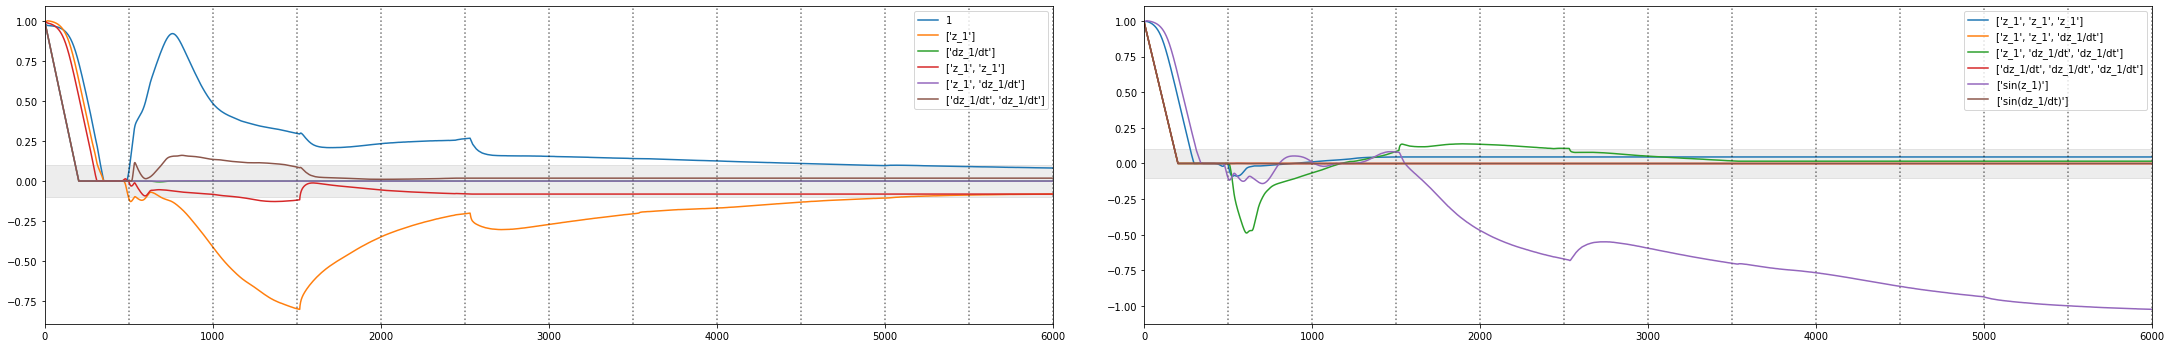

In [8]:
m = model_names[2]
xlim = 6002
split_size = 6

fig, ax = plt.subplots(1, 2, figsize=(30, 5))
fig.tight_layout(w_pad=6, h_pad=5)

for split in range(2):
    for i, (n, c) in enumerate(
        zip(VerboseLibrary(model.library).build_verbose()[split*split_size:(split+1)*split_size],
        model_coefficient_history[m].reshape(6002, 12).T[split*split_size:(split+1)*split_size],
        )):
        ax[split].plot(c[:xlim].T, label=n, color=named_colors[i])
        ax[split].legend(); ax[split].axhspan(-0.1, 0.1, color='black', alpha=0.01); ax[split].set_xlim(0, xlim);# ax[split].set_ylim(-0.1, 0.1)
        for threshold_epoch in np.arange(500, xlim, 500): ax[split].axvline(threshold_epoch, color='black', alpha=0.1, linestyle=':')

In [7]:
model_sin_history = {name: model_coefficient_history[name][:, 10, 0] for name in model_names}
model_other_history = {name: model_coefficient_history[name][:, [i for i in range(12) if i != 10], 0] for name in model_names}

# Thresholding

In [8]:
def trend(a, lengthscale=5):
    mean_diff_last_values, var_last_values = np.mean(a[-2*lengthscale:-lengthscale], axis=0), np.var(a[-2*lengthscale:-lengthscale], axis=0)
    mean_diff_now_values, var_now_values = np.mean(a[-lengthscale:], axis=0), np.var(a[-lengthscale:], axis=0)
    return mean_diff_now_values - mean_diff_last_values, np.sqrt(var_last_values + var_now_values)

In [9]:
def trend_speed(a, lengthscale=5):
    if a.shape[0] > 2*lengthscale:
        return trend(a, lengthscale)[0]
    return np.zeros(a.shape[1:])

In [10]:
def trend_significance(a, lengthscale=5):
    if a.shape[0] > 2*lengthscale:
        t = trend(a, lengthscale)
        r = np.copy(t[0])
        r[(t[0] != 0) & (t[1] == 0)] = np.nan
        r[(t[0] != 0) & (t[1] != 0)] = t[0][(t[0] != 0) & (t[1] != 0)] / t[1][(t[0] != 0) & (t[1] != 0)]
        return r
    return np.zeros(a.shape[1:])

In [11]:
model_trend_significances = {}
model_trend_speed = {}
for name in model_names:
    model_trend_significances[name] = np.stack([trend_significance(model_coefficient_history[name][:i]) for i in range(6000)])
    model_trend_speed[name] = np.stack([trend_speed(model_coefficient_history[name][:i]) for i in range(6000)])

In [12]:
model_classified_history = {}
model_classified_plus_history = {}

for name in tqdm(model_names):
    ptat = PatientTrendAwareThresholder()
    model_classified_history[name] = np.stack([ptat.classify_converged(model_coefficient_history[name][:i])[0] for i in range(1, len(model_coefficient_history[name]))])

100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


In [13]:
model_coefficient_activity_history = {name: (model_coefficient_history[name][1:] - model_coefficient_history[name][:-1]).astype(bool) for name in model_names}
model_thresholded_epochs = {name: np.where((~model_coefficient_activity_history[name][1:] & model_coefficient_activity_history[name][:-1])) for name in model_names}
model_before_thresholded_epochs = {name: (model_thresholded_epochs[name][0] - 5, model_thresholded_epochs[name][1], model_thresholded_epochs[name][2]) for name in model_names}

model_before_thresholded_epochs[model_names[2]]

(array([1196, 1198, 1198, 1198, 1201, 2209, 2311, 2522, 3587, 4055, 4259]),
 array([ 9,  2,  4, 11,  7,  6,  5,  3,  0,  1, 10]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [14]:
model_thresholded_trend_speed_values = {name: model_trend_speed[name][model_before_thresholded_epochs[name]] for name in model_names}
model_thresholded_trend_significance_values = {name: model_trend_significances[name][model_thresholded_epochs[name]] for name in model_names}
model_thresholded_coefficient_values = {name: model_coefficient_history[name][model_thresholded_epochs[name]] for name in model_names}

In [15]:
all_models_thresholded_coefficient_values = []
all_models_thresholded_trend_significance_values = []
all_models_thresholded_trend_speed_values = []

for name in model_names:
    all_models_thresholded_coefficient_values.extend(model_thresholded_coefficient_values[name])
    all_models_thresholded_trend_significance_values.extend(model_thresholded_trend_significance_values[name])
    all_models_thresholded_trend_speed_values.extend(model_thresholded_trend_speed_values[name])

In [16]:
sin_models_thresholded_coefficient_values, any_models_thresholded_coefficient_values, none_models_thresholded_coefficient_values = [], [], []
sin_models_thresholded_trend_significance_values, any_models_thresholded_trend_significance_values, none_models_thresholded_trend_significance_values = [], [], []
sin_models_thresholded_trend_speed_values, any_models_thresholded_trend_speed_values, none_models_thresholded_trend_speed_values = [], [], []

for name in model_names:
    if model_sin_detected[name]:
        sin_models_thresholded_coefficient_values.extend(model_thresholded_coefficient_values[name])
        sin_models_thresholded_trend_significance_values.extend(model_thresholded_trend_significance_values[name])
        sin_models_thresholded_trend_speed_values.extend(model_thresholded_trend_speed_values[name])
    elif model_any_detected[name]:
        any_models_thresholded_coefficient_values.extend(model_thresholded_coefficient_values[name])
        any_models_thresholded_trend_significance_values.extend(model_thresholded_trend_significance_values[name])
        any_models_thresholded_trend_speed_values.extend(model_thresholded_trend_speed_values[name])
    elif model_none_detected[name]:
        none_models_thresholded_coefficient_values.extend(model_thresholded_coefficient_values[name])
        none_models_thresholded_trend_significance_values.extend(model_thresholded_trend_significance_values[name])
        none_models_thresholded_trend_speed_values.extend(model_thresholded_trend_speed_values[name])

In [17]:
reasonable_cutoff = 0.2/5 # coefficient may change by double the ST-Zone in 5000 epochs
unreasonable_cutoff = 0.2/0.1 # coefficient may change by double the ST-Zone in 100 epochs

In [18]:
ptat_used_trend_threshold = 0.002 # per epoch

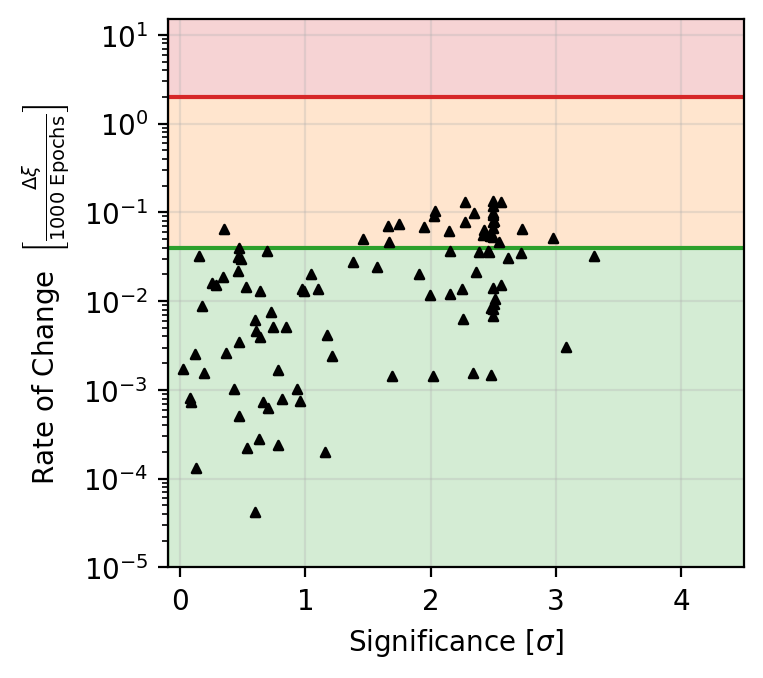

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6.5/1.8, 6/1.8), dpi=200)
fig.tight_layout(w_pad=5)

# trend in 5 Epochs is 200 * trend in 1000 Epochs
ax.scatter(np.abs(all_models_thresholded_trend_significance_values), np.abs(all_models_thresholded_trend_speed_values) * 200, color='black', marker='^', s=10, zorder=3);
ax.set_ylabel(r'Rate of Change  $\left[\frac{\Delta \xi}{1000 \,\,\mathrm{Epochs}}\right]$'); ax.set_xlabel(r'Significance $[\sigma]$'); ax.set_yscale('log'); ax.grid(alpha=0.3, zorder=1);
ax.axhspan(1e-6, reasonable_cutoff, color='tab:green', alpha=0.2);
ax.axhspan(reasonable_cutoff, unreasonable_cutoff, color='tab:orange', alpha=0.2);
ax.axhspan(unreasonable_cutoff, 100, color='tab:red', alpha=0.2);
ax.axhline(unreasonable_cutoff, color='tab:red',)
ax.axhline(reasonable_cutoff, color='tab:green')
# ax.axhline(1e3*ptat_used_trend_threshold, color='black', alpha=0.5, linestyle='--', label=r'$b = 0.002$')
ax.set_ylim(1e-5, 15), ax.set_xlim(-0.1, 4.5);
# ax.legend(); 